In [1]:
import numpy as np
import pandas as pd

import os,ast,shutil,copy

from bokeh.plotting import figure, gridplot 
from bokeh.io import output_file, show, output_notebook
output_notebook()


def bokeh_show(
        params,
        df_cross,
        show_figures1, 
        show_figures2, wps_fig2,
        color_cross):

    colors = [subm['color'] for subm in params['subm']]
    
    def dossier(js,subms,cols):
        def quant(i,js,subms,cols):
            return {"c" : i, "q" : sum([1 for subm in cols[i] if subm == subms[js]])}
        return {
            'name' : subms[js],
            'q_in' : [quant(i,js,subms,cols) for i in range(len(subms))]
        }
    alls = pd.read_csv(f'tida_desc.csv')
    matrix = [ast.literal_eval(str(row.alls)) for row in alls.itertuples()]
    subms = sorted(matrix[0])
    cols = [[data[i] for data in matrix] for i in range(len(subms))]
    df_subms = pd.DataFrame({f'col_{i}': [x[i] for x in matrix] for i in range(len(subms))})
    dossiers = [dossier(js,subms,cols) for js in range(len(subms))]
    subm_names = [one_dossier['name'] for one_dossier in dossiers]
    figures1,qss,i = [],[],0
    height = 100 if len(colors)==2\
        else 134 if len(colors)==3 else (154 if len(colors)==4 else 174)
    for one_dossier in dossiers: 
        i_col = 'alls. ' + str(one_dossier['q_in'][i]['c'])
        qs = [one['q'] for one in one_dossier['q_in']]
        x_names = [name.replace("Group","").replace("subm_","") for name in subm_names]
        width = 157  if len(colors) == 5\
            else (140 if len(colors) == 4\
            else (121 if len(colors) == 8\
            else (131 if len(colors) == 9\
            else (141 if len(colors) == 10\
            else (171 if len(colors) == 11 else 130)))))
        f = figure(x_range=x_names,width=width, height=height, title=i_col)
        f.vbar(x=x_names, width=0.585, top=qs, color=colors)
        figures1.append(f)
        qss.append(qs)
        i+=1
    grid = gridplot([figures1])
    output_file('tida_alls.html')
    if show_figures1 == True: show(grid)
    sub_wts = params['subwts']
    main_wts = [subm['weight'] for subm in params['subm']]
    mms,acc_mass = [],[]
    for j in range(len(dossiers)):
        one_dossier = dossiers[j]
        qs = [one['q'] for one in one_dossier['q_in']]
        mm = [qs[h] * (main_wts[j] + sub_wts[h]) for h in range(len(sub_wts))]
        mass = sum(mm)
        mms.append(mm)
        acc_mass.append(round(mass))                        #subm_names[::-1]
    y_names = [name + " - " + str(mass) for name,mass in zip(subm_names,acc_mass)]
    f1 = figure(y_range=y_names, width=270, height=height, title='relations of general masses')
    f1.hbar(y=y_names, height=0.555, right=acc_mass, left=0, color=colors)
    output_file('tida_alls2.html')
    alls = [f'alls.{i}' for i in range(len(dossiers))]
    subm = [f'sub{i}'   for i in range(len(dossiers))] 
    mmsT  = np.asarray(mms).T
    data = {'cols' : alls}
    for i in range(len(dossiers)): data[f'sub{i}'] = mmsT[i,:]
    f2 = figure(y_range=alls, height=height, width=270, title="relations of columns masses")
    f2.hbar_stack(subm, y='cols', height=0.555, color=colors, source=data)
    qssT  = np.asarray(qss).T
    data = {'cols' : alls}
    for i in range(len(dossiers)): data[f'sub{i}'] = qssT[i,:]
    f3 = figure(y_range=alls, height=height, width=245, title="ratios in columns")
    f3.hbar_stack(subm, y='cols', height=0.555, color=colors, source=data)
    grid = gridplot([[f3,f2,f1]])
    show(grid)
    if show_figures2 == True:
        def read(params,i):
            FiN = params["path"] + params["subm"][i]["name"] + ".csv"
            target_name_back = {'target':params["target"],'pred':params["target"]}
            return pd.read_csv(FiN).rename(columns=target_name_back)
        dfs = [read(params,i) for i in range(len(params["subm"]))] + [df_cross]
        _height = 333 if len(params["subm"]) == 10 else 254
        f   = figure(width=785, height=_height)
        f.title.text = 'Click on legend entries to mute the corresponding lines'
        b,e        = 21000,22000
        line_x     = [dfs[i][b:e]['id']             for i in range(len(dfs))]
        line_y     = [dfs[i][b:e]['diagnosed_diabetes'] for i in range(len(dfs))]
        color      = colors + [color_cross]
        alpha      = [0.8 for i in range(len(dfs)-1)] + [0.95]
        lws        = [1.0 for i in range(len(dfs)-1)] + [1.00]
        legend = subm_names + ['cross']
        for i in range(len(legend)):
            f.line(line_x[i], line_y[i], line_width=lws[i], color=color[i], alpha=alpha[i],
                   muted_color='white',legend_label=legend[i])
        f.legend.location = "top_left"
        f.legend.click_policy="mute"
        show(f)


def matrix_vs(path,fs_names):
    def load(path,fs_names):
        dfs = [pd.read_csv(path + name_subm +'.csv') for name_subm in fs_names]
        for i in range(len(dfs)):
            dfs[i] = dfs[i].rename(columns={"diagnosed_diabetes": f'{fs_names[i]}'})
        dfsm = pd.merge(dfs[0], dfs[1], on="id")
        for i in range(2,len(dfs)):
            dfsm = pd.merge(dfsm,dfs[i],on='id')
        return dfsm   
    def make_list_vs(fs_names):
        list = []
        for i in range(0,len(fs_names)-1):
            for j in range(i+1,len(fs_names)):
                list.append(fs_names[i] + "_vs_" + fs_names[j])
        return list
    def get_mvs(dfs, list_vs):
        def get_abs_distance(x,t1,t2):
            return abs(x[t1]-x[t2])
        for vs in list_vs:
            t = vs.split('_vs_')
            dfs[vs] = dfs.apply(lambda x: get_abs_distance(x,t[0],t[1]), axis=1)
        return dfs   
    def distance_vs(name, st_names, list_vs, dfs):
        distances = []
        for st in st_names:
            vs_between = name + "_vs_" + st
            if vs_between not in list_vs:
                distances.append(0)
            else: distances.append(round(dfs[vs_between].sum()))
        return distances
    dfs = load(path,fs_names)
    list_vs = make_list_vs(fs_names)
    mvs = get_mvs(dfs, list_vs)
    m1 = pd.DataFrame({'subm':fs_names})
    m2 = pd.DataFrame({ name :distance_vs(name, fs_names, list_vs, mvs) for name in fs_names})
    matrix = pd.concat([m1,m2],axis=1)
    return matrix


def seaborn_Show(params):
    import matplotlib.pyplot as plt, seaborn as sns
    import warnings; warnings.filterwarnings('ignore')
    plt.figure(figsize=(9, 3.5))
    for subm in params['subm']:
        pred = pd.read_csv(params['path']+subm['name']+'.csv')[params['id_target'][1]]
        sns.kdeplot(pred, label = subm['name'], linewidth = 1)
    plt.title("KDE")
    plt.xlabel("target")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


def display_distances(params):
    files = [subm['name'] for subm in params['subm']]
    distances = matrix_vs ( params['path'], files )            
    display(distances)


def arr_colors(color):
    sg = ['silver','gainsboro']
    if color=='red'   or color=='r': return ['red','crimson','firebrick']            + sg
    if color=='Red'   or color=='R': return ['red','tomato','crimson']               + sg
    if color=='Green' or color=='G': return ['forestgreen','limegreen', 'darkgreen'] + sg
    if color=='Blue'  or color=='B': return ['blue','royalblue','mediumblue']        + sg
    if color=='RGB'   or color=='S': return ['mediumblue','darkgreen','crimson']     + sg
    return ['black','dimgray','gray'] + sg


def convert(schema):
    colors = arr_colors(schema[2])
    dicts  = [
        {'name': schema[0][i],'weight':schema[1][i],'color':colors[i]} 
        for i in range(len(schema[0]))
    ]
    return {'subm':dicts}


def h_blend(
        params, _update={},
        cross='silver',
        details=False,
        fig1=False, fig2=False, wf2=555, 
        dtls=False, dist=False, subm=''):

    if isinstance(params, list): params = convert(params)

    if 'path' in _update: params.update(_update)
    
    color_cross, dk  = cross, copy.deepcopy(params)

    if details == True:
        dist = True
        show_details,show_figures1,show_figures2 = True,True,True
    else:
        show_details,show_figures1,show_figures2 = dtls,fig1,fig2
        
    file_short_names = [subm['name'] for subm in params['subm']]
    type_sort    = params['type_sort'][0]
    dk['asc']    = params['type_sort'][1]
    dk['desc']   = params['type_sort'][2]
    dk['id']     = params['id_target'][0]
    dk['target'] = params['id_target'][1]
# ------------------------------------------------------------------------
    def read(dk,i):
        tnm = dk["subm"][i]["name"]
        FiN = dk["path"] + tnm + ".csv"
        return pd.read_csv(FiN).rename(columns={
            'target':tnm, 'pred':tnm, dk["target"]:tnm})
        
    def merge(dfs_subm):
        df_subms = pd.merge(dfs_subm[0],  dfs_subm[1], on=[dk['id']])
        for i in range(2, len(dk["subm"])): 
            df_subms = pd.merge(df_subms, dfs_subm[i], on=[dk['id']])
        return df_subms
        
    def da(dk,sorting_direction,show_details):
        
        df_subms = merge([read(dk,i) for i in range(len(dk["subm"]))])
        cols = [col for col in df_subms.columns if col != dk['id']]
        short_name_cols = [c for c in cols]
        
        def alls1(x, sd=sorting_direction,cs=cols):
            reverse = True if sd=='desc' else False
            tes = {c: x[c] for c in cs}.items()
            subms_sorted = [t[0] for t in sorted(tes,key=lambda k:k[1],reverse=reverse)]
            return subms_sorted

        import random

        def alls2(x, sd=sorting_direction,cs=cols):
            reverse = True if sd=='desc' else False
            tes = {c: x[c] for c in cs}.items()
            subms_random = [t[0] for t in tes]
            random.shuffle(subms_random)
            return subms_random

        alls = alls1 if type_sort == 'asc/desc' else alls2
            
        def summa(x,cs,wts,ic_alls): 
            return sum([x[cs[j]] * (wts[0][j] + wts[1][ic_alls[j]]) for j in range(len(cs))])
            
        wts = [[[e['weight'] for e in dk["subm"]], [w for w in dk["subwts"]]]]
          
        def correct(x, cs=cols, wts=wts):
            i = [x['alls'].index(c) for c in short_name_cols]
            return summa(x,cs,wts[0],i)

        if len(wts) == 1:
            correct_sub_weights = [wt for wt in dk["subwts"]]
            weights = [subm['weight'] for subm in dk["subm"]]
            def correct(x, cs=cols, w=weights, cw=correct_sub_weights):
                ic = [x['alls'].index(c) for c in short_name_cols]
                cS = [x[cols[j]] * (w[j] + cw[ic[j]]) for j in range(len(cols))]
                return sum(cS)
                
        if len(wts) > 1 or "subwts2" in dk:

            wts = [
                [[e['weight'] for e in dk["subm"]], [w for w in dk["subwts" ]]],
                [[e['weight'] for e in dk["subm2"]],[w for w in dk["subwts2"]]],
                [[e['weight'] for e in dk["subm3"]],[w for w in dk["subwts3"]]],
            ]

            def correct(x, cs=cols, wts=wts):
                i = [x['alls'].index(c) for c in short_name_cols]
                if   0.000 <= x['mx-m'] < 0.030: return summa(x,cs,wts[0],i)
                if   0.030 <= x['mx-m'] < 0.047: return summa(x,cs,wts[2],i)
                else:                            return summa(x,cs,wts[1],i)
                   
        def amxm(x, cs=cols):
            list_values = x[cs].to_list()
            mxm = abs(max(list_values)-min(list_values))
            return mxm

        if len(wts) > 1 or "subwts2" in dk:
            df_subms['mx-m']   = df_subms.apply(lambda x: amxm   (x), axis=1)
        df_subms['alls']       = df_subms.apply(lambda x: alls   (x), axis=1)
        df_subms[dk["target"]] = df_subms.apply(lambda x: correct(x), axis=1)
        schema_rename = { old_nc:new_shnc for old_nc, new_shnc in zip(cols, short_name_cols) }
        df_subms = df_subms.rename(columns=schema_rename)
        df_subms = df_subms.rename(columns={dk["target"]:"ensemble"})
        df_subms.insert(loc=1, column=' _ ', value=['   '] * len(df_subms))
        df_subms[' _ '] = df_subms[' _ '].astype(str)
        pd.set_option('display.max_rows',100)
        pd.set_option('display.float_format', '{:.5f}'.format)
        if len(wts) > 1: 
            vcols = [dk['id']] + [' _ '] + short_name_cols + [' _ '] + ['mx-m'] + [' _ '] +\
                      ['alls'] + [' _ '] + ['ensemble']
        else:
            vcols = [dk['id']] + [' _ '] + short_name_cols + [' _ '] +\
                      ['alls'] + [' _ '] + ['ensemble']
        df_subms = df_subms[vcols]
        if show_details and sorting_direction=='desc': display(df_subms.head(5))
        pd.set_option('display.float_format', '{:.5f}'.format)
        df_subms = df_subms.rename(columns={"ensemble":dk["target"]})
        if sorting_direction=='desc': 
            df_subms.to_csv(f'tida_{sorting_direction}.csv', index=False)
        return df_subms[[dk['id'],dk['target']]]
   
    def ensemble_da(dk,        show_details): 
        dfD    = da(dk,'desc', show_details)
        dfA    = da(dk,'asc',  show_details)
        dfA[dk['target']] = dk['desc']*dfD[dk['target']] + dfA[dk['target']]*dk['asc']
        return dfA

    da = ensemble_da(dk,show_details)
    bokeh_show(dk, da, show_figures1, show_figures2, wf2, color_cross)

    if subm != '': da.to_csv(subm, index=False)
        
    if dist == True: 
        if subm != '' and '/kaggle/working/' in params['path']: 
            params['subm'].append({'name':subm.replace('.csv','').replace(params['path'],'')})
        display_distances(params)
        seaborn_Show(params)
    
    return  da

Loading BokehJS ...

,id,_,442,447,541,598w,_,mx-m,_,alls,_,ensemble
0,700000,,0.48691,0.49217,0.48068,0.45212,,0.04005,,"[447, 442, 541, 598w]",,0.45245
1,700001,,0.69777,0.70117,0.67896,0.65686,,0.04431,,"[447, 442, 541, 598w]",,0.65720
2,700002,,0.78035,0.75554,0.76388,0.75045,,0.02990,,"[442, 541, 447, 598w]",,0.75081
3,700003,,0.42597,0.40478,0.39636,0.36685,,0.05912,,"[442, 447, 541, 598w]",,0.36730
4,700004,,0.91017,0.89350,0.90595,0.91482,,0.02132,,"[598w, 442, 541, 447]",,0.91473


,subm,442,447,541,598w
0,442,0,0,0,0
1,447,7024,0,0,0
2,541,5516,4806,0,0
3,598w,10693,8197,7696,0


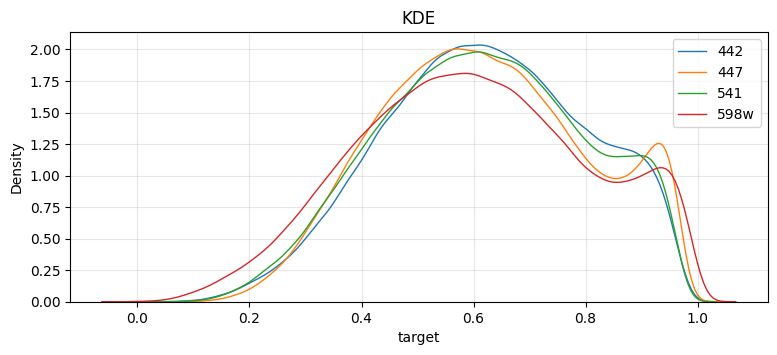

In [2]:
params = {
      'path'     : f'/kaggle/input/14-december-2025-ps-s5e12/0.70',            
      'id_target': ['id',"diagnosed_diabetes"],          
      'type_sort': ['asc/desc',0.10,0.90 ],

      'different': [0,2,1],
      
      'subwts'   : [w/10_100 for w in [ +11,-1,-3,-7 ]],
      'subm'     : [
          {'name': f'442', 'weight':+0.0092, 'color':'blue'   },
          {'name': f'447', 'weight':+0.0017, 'color':'orange' },
          {'name': f'541', 'weight':+0.0037, 'color':'green'  },
          {'name': f'598w','weight':+0.9854, 'color':'crimson'},],

      'subwts2'  : [w/10_200 for w in [ +11,-1,-3,-7 ]],
      'subm2'    : [
          {'name': f'442', 'weight':+0.0037, 'color':'blue'   },
          {'name': f'447', 'weight':+0.0017, 'color':'orange' },
          {'name': f'541', 'weight':+0.0037, 'color':'green'  },
          {'name': f'598w','weight':+0.9909, 'color':'crimson'},],

      'subwts3'  : [w/10_300 for w in [ +11,-1,-3,-7 ]],
      'subm3'    : [
          {'name': f'442', 'weight':+0.0047, 'color':'blue'   },
          {'name': f'447', 'weight':+0.0007, 'color':'orange' },
          {'name': f'541', 'weight':+0.0037, 'color':'green'  },
          {'name': f'598w','weight':+0.9909, 'color':'crimson'},],
}
df = h_blend(params, details=True)

## Submit

In [3]:
df.to_csv('submission.csv',index=False)
df

,id,diagnosed_diabetes
0,700000,0.45244
1,700001,0.65719
2,700002,0.75081
3,700003,0.36729
4,700004,0.91472
...,...,...
299995,999995,0.76201
299996,999996,0.64750
299997,999997,0.55881
299998,999998,0.59128
